In [ ]:
%env OMP_NUM_THREADS=8

In [ ]:
%env THEANO_FLAGS=device=gpu3,floatX=float32

import theano, lasagne
import theano.tensor as T
from lasagne.layers import *

In [ ]:
%pylab inline
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import theano
import theano.tensor as T
import lasagne

from lasagne.regularization import regularize_layer_params_weighted, l2, l1
from lasagne.regularization import regularize_layer_params


In [ ]:
from itertools import *


In [71]:
%reload_ext autoreload
%autoreload 2

import dem
import custom_nn
import class_helper

In [ ]:
def preprocess1(str1, str2):
    X1, hypo1, y1, energy1, X2, hypo2, y2, energy2 =  dem.write_data(str1, str2)
    X_all = np.concatenate((X1, X2), axis=0)
    print "X_all shape", X_all.shape
    Y_all = np.concatenate((y1, y2), axis=0)
    #weights = get_weight(energy1, energy2)
    return X_all, Y_all

** Total data uses on simple training **

In [ ]:
X,Y = preprocess1("Area2Pi.pcl", "Area2Ph_1.pcl")

** Cut data - we use it on cv **

In [ ]:
import numpy as np
ix = np.arange(len(X))
np.random.shuffle(ix)
X = X[ix]
Y = Y[ix]
X_cut = X[:100000]
Y_cut = Y[:100000]

In [ ]:
%pylab inline

#X_train,X_val,y_train,y_val, w_train, w_test= dem.preprocess("Area2Pi.pcl", "Area2Ph.pcl")
X_train,X_val,y_train,y_val, w_train, w_test = dem.preprocess("Area2Pi.pcl", "Area2Ph_1.pcl")

print "Xtrain [форма - %s]:", X_train[0].shape
print "Xtest [форма - %s]:", X_train[0].shape


In [ ]:
updates = {'adamax':lasagne.updates.adamax, \
               'adagrad':lasagne.updates.adagrad,\
               'sgd':lasagne.updates.sgd,\
               'rmsprop':lasagne.updates.rmsprop}


# 1 . Plateaux

** Firstly run heavy (3*300) NN 300 epoch **

In [ ]:
test_curve_h = list()
train_curve_h = list()

train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn3(-2, "All", ecal_units=300, ps_units = 10, drop_ = 0, drop_ps = 0)
initial = 0
for epoch in range(600):
    for Xb,yb in class_helper.iterate_minibatches(X_train,y_train,100,shuffle=True):
        _ = train_fun1(Xb, yb)

    y_proba_1 = predict_fun(X_train)
    y_proba_2 = predict_fun(X_val)
    roc_auc_test = roc_auc_score(y_val, y_proba_2[:,1])
    test_curve_h.append(roc_auc_test)
    roc_auc_train_h = roc_auc_score(y_train, y_proba_1[:,1])
    train_curve.append(roc_auc_train)
    if (initial == 0 or initial == 99 or initial == 199 or initial == 299 or initial == 399):
        print initial
        print "test", roc_auc_test
        print "train", roc_auc_train 
    initial = initial + 1
fpr_, tpr_, thresholds_ = roc_curve(y_val, y_proba_2[:,1])

All
0
test 0.762399793452
train 0.767522683836
99
test 0.874526040534
train 0.879267444618
199
test 0.885167669761
train 0.891655966124
299
test 0.893352994566
train 0.900402047628
399
test 0.897779433504
train 0.904258128165


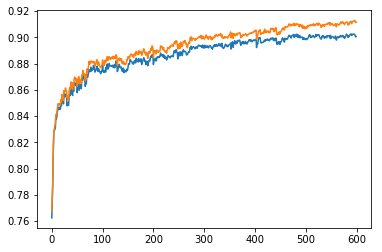

In [67]:
plt.plot(test_curve)
plt.plot(train_curve)
plt.savefig('N4_600epoch.png')

with open("pleteaux3l.pcl",'w') as fout:
    pickle.dump([test_curve, train_curve] ,fout) # не сохранилось!!!


** Then run (2\*250/2*10) **

In [150]:
test_curve_l = list()
train_curve_l = list()

train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn_250_10(-2, "All")
initial = 0
for epoch in range(300):
    for Xb,yb in class_helper.iterate_minibatches(X_train,y_train,100,shuffle=True):
        _ = train_fun1(Xb, yb)

    y_proba_1 = predict_fun(X_train)
    y_proba_2 = predict_fun(X_val)
    roc_auc_test = roc_auc_score(y_val, y_proba_2[:,1])
    test_curve_l.append(roc_auc_test)
    roc_auc_train = roc_auc_score(y_train, y_proba_1[:,1])
    train_curve_l.append(roc_auc_train)
    if (initial == 0 or initial == 99 or initial == 199 or initial == 299 or initial == 399):
        print initial
        print "test", roc_auc_test
        print "train", roc_auc_train 
    initial = initial + 1
fpr_, tpr_, thresholds_ = roc_curve(y_val, y_proba_2[:,1])

All
0
test 0.651375478452
train 0.648286752736
99
test 0.759513598261
train 0.759918609892
199
test 0.768983392996
train 0.771117895371
299
test 0.770603204522
train 0.774574182037


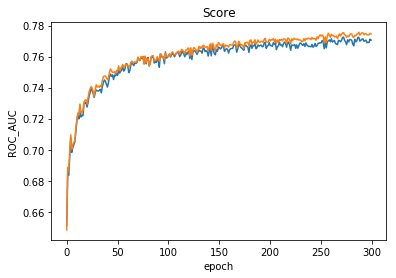

In [151]:
plt.title("Score")
plt.xlabel('epoch')
plt.ylabel('ROC_AUC')
plt.plot(test_curve_l)
plt.plot(train_curve_l)
plt.savefig('N4_300epoch.png')

with open("pleteaux2l.pcl",'w') as fout:
    pickle.dump([test_curve_l, train_curve_l, [], []],fout)


** It's seems to be OK to run 200 epoch to 1-2 layer NN and 500 epoch to 3-4 layer NN.If i run all, i take 500 **

## 2. Stability

**Then run (2\*250/2*10) 5 times with different init**

All
test 0.635610358831
train 0.638660172842
test 0.772513983092
train 0.775331113353
test 0.777179129575
train 0.7840260983
All
test 0.663067734314
train 0.663627942313
test 0.773169221899
train 0.777870120022
test 0.778072656427
train 0.784715352216
All
test 0.707451497804
train 0.705327839251
test 0.773417667771
train 0.778344316521
test 0.778023280125
train 0.783866336218
All
test 0.658327981112
train 0.66106492748
test 0.776985496687
train 0.779653406814
test 0.780280923253
train 0.786782487729
All
test 0.616542632015
train 0.615562537867
test 0.764702700645
train 0.769446802526
test 0.776783809092
train 0.783228470224


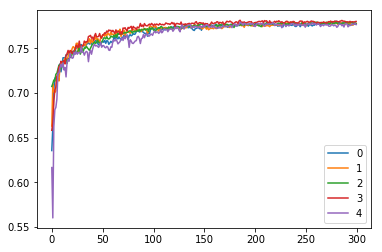

In [95]:
save_list = []
for i in range(5):
    test_curve = list()
    train_curve = list()

    train_fun1, accuracy_fun1, predict_fun1 = custom_nn.make_nn_250_10(-2, "All") #2 layer as higher 400 units&
    
    test_, train_ = class_helper.single_train(train_fun1, predict_fun1, X_train,y_train,  X_val,y_val, 300)
    save_list.append(train_)
    plt.plot(train_,label=str(i))
    
with open("stability.pcl",'w') as fout:
    pickle.dump(save_list,fout)

plt.legend()
plt.savefig('diff_init.png')
plt.show()

** Seems to be stable **

##  3. Overfitting ##
** Calorimeter / preshower data **

## 2 layers: ##
* **calorimeter branch 250, ps 50** 
* **cl 250 ps 10** 
* **cl 250**

In [ ]:
train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn2(-2, 'Calo', ecal_units=250, ps_units = 10, drop_ = 0, drop_ps = 0)
initial = 0

test_curve4, train_curve4 = class_helper.single_train(train_fun1, predict_fun, X_train,y_train,  X_val,y_val, 500)

train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn2(-2, 'All', ecal_units=250, ps_units = 10, drop_ = 0, drop_ps = 0)
initial = 0

test_curve5, train_curve5 = class_helper.single_train(train_fun1, predict_fun, X_train,y_train,  X_val,y_val, 500)

train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn2(-2, 'All', ecal_units=250, ps_units = 50, drop_ = 0, drop_ps = 0)
initial = 0

test_curve6, train_curve6 = class_helper.single_train(train_fun1, predict_fun, X_train,y_train,  X_val,y_val, 500)


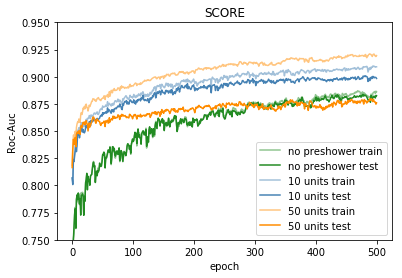

In [86]:
plt.title('SCORE')
plt.ylim(0.75, 0.95)
plt.ylabel('Roc-Auc')
plt.xlabel('epoch')
plt.plot(test_curve4, color = 'forestgreen', label = 'no preshower train', alpha = 0.5)
plt.plot(train_curve4, color = 'forestgreen', label = 'no preshower test')
plt.plot(test_curve5, color = 'steelblue', label = '10 units train', alpha = 0.5)
plt.plot(train_curve5, color = 'steelblue', label = '10 units test')
plt.plot(test_curve6, color='darkorange', label = '50 units train', alpha = 0.5)
plt.plot(train_curve6, color='darkorange', label = '50 units test')
plt.legend(loc='lower right')
plt.savefig("simple_ecal_vs_ps_2l-1.png")
plt.show()

** Save **

In [87]:
import pickle
with open("ov_f_2nn.pcl",'w') as fout:
    pickle.dump([test_curve4, train_curve4, test_curve5, train_curve5, test_curve6, train_curve6],fout)


## 3 layers: ##
* **calorimeter branch 250, ps 50** 
* **cl 250 ps 10** 
* **cl 250**

In [ ]:
train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn3(-2, 'Calo', ecal_units=100, ps_units = 10, drop_ = 0, drop_ps = 0)
initial = 0

test_curve, train_curve = class_helper.single_train(train_fun1, predict_fun, X_train,y_train,  X_val,y_val, 500)

train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn3(-2, 'All', ecal_units=100, ps_units = 10, drop_ = 0, drop_ps = 0)
initial = 0

test_curve1, train_curve1 = class_helper.single_train(train_fun1, predict_fun, X_train,y_train,  X_val,y_val, 500)

train_fun1, accuracy_fun1, predict_fun = custom_nn.make_nn3(-2, 'All', ecal_units=100, ps_units = 50, drop_ = 0, drop_ps = 0)
initial = 0

test_curve0, train_curve0 = class_helper.single_train(train_fun1, predict_fun, X_train,y_train,  X_val,y_val, 500)

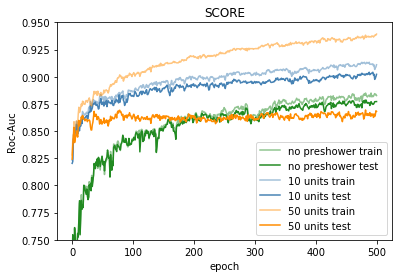

In [85]:
plt.title('SCORE')
plt.ylim(0.75, 0.95)
plt.ylabel('Roc-Auc')
plt.xlabel('epoch')
plt.plot(test_curve, color = 'forestgreen', label = 'no preshower train', alpha = 0.5)
plt.plot(train_curve, color = 'forestgreen', label = 'no preshower test')
plt.plot(test_curve1, color = 'steelblue', label = '10 units train', alpha = 0.5)
plt.plot(train_curve1, color = 'steelblue', label = '10 units test')
plt.plot(test_curve0, color='darkorange', label = '50 units train', alpha = 0.5)
plt.plot(train_curve0, color='darkorange', label = '50 units test')
plt.legend(loc='lower right')
plt.savefig("simple_ecal_vs_ps_3l-1.png")
plt.show()

** Save **

In [88]:
with open("ov_f_3nn.pcl",'w') as fout:
    pickle.dump([test_curve, train_curve, test_curve1, train_curve1, test_curve0, train_curve0],fout)

** In  the same configuration: ** 
* dropping PS enformation cannot make score better 
* on "big" number of layer much PS gives pronounced overfitting 


** Conclusion: on 3-4 layer NN we take only 10 units for PS brunch**

## 4. Launch with different number of layers ##
* In every configuration number of units varies 

## Result of 1-layer - global_score_1 ##

In [126]:
global_score_1 = [array([ 0.86609997,  0.84678031,  0.85868345]),
 array([ 0.87782866,  0.86636827,  0.85786629]),
 array([ 0.86725485,  0.86787217,  0.87454579]),
 array([ 0.86725485,  0.86787217,  0.87454579]),
 array([ 0.86175467,  0.85643305,  0.85853045]),
 array([ 0.86023254,  0.85719995,  0.86773078])]

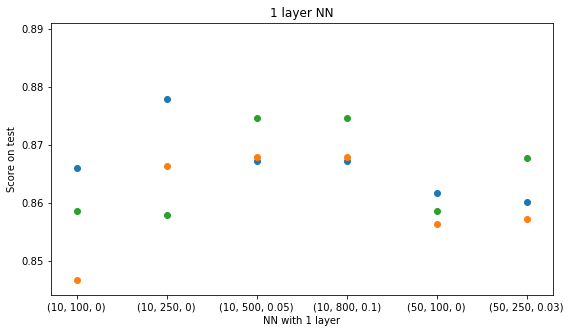

In [127]:
plt.figure(figsize=(9,5))
y0 = [global_score_1[0][0], global_score_1[1][0], global_score_1[2][0], global_score_1[3][0], global_score_1[4][0], global_score_1[5][0]]
y1 = [global_score_1[0][1], global_score_1[1][1], global_score_1[2][1], global_score_1[3][1], global_score_1[4][1], global_score_1[5][1]]
y2 = [global_score_1[0][2], global_score_1[1][2], global_score_1[2][2], global_score_1[3][2], global_score_1[4][2], global_score_1[5][2]]

x = [1,2,3,4,5,6]
my_xticks = ['(10, 100, 0)', '(10, 250, 0)','(10, 500, 0.05)','(10, 800, 0.1)','(50, 100, 0)', '(50, 250, 0.03)']
plt.xticks(x, my_xticks)
plt.scatter(x, y0)
plt.scatter(x, y1)
plt.scatter(x, y2)

plt.xlabel('NN with 1 layer')
plt.ylabel('Score on test')
plt.title("1 layer NN")
plt.savefig('NN_with_1_layer.jpg')

## Result of 2-layer - global_score_2 ##

In [167]:
global_score_2 = [array([ 0.86931355,  0.87661713,  0.87362958]),
 array([ 0.86845637,  0.84661837,  0.87104118]),
 array([ 0.84442579,  0.83875455,  0.85182038]),
 array([ 0.84351987,  0.83249297,  0.83869526]),
 array([ 0.82796763, 0.81723464,  0.84293842]),
 array([ 0.81541518,  0.81458568,  0.81898839])]

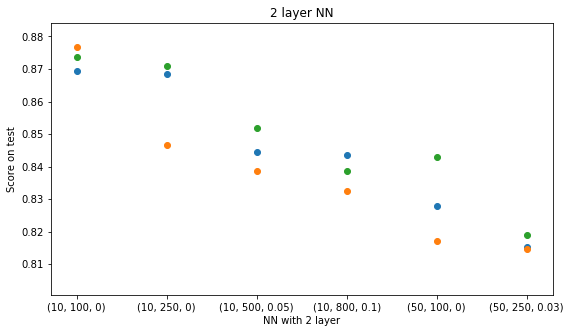

In [168]:
plt.figure(figsize=(9,5))
y0 = [global_score_2[0][0], global_score_2[1][0], global_score_2[2][0], global_score_2[3][0], global_score_2[4][0], global_score_2[5][0]]
y1 = [global_score_2[0][1], global_score_2[1][1], global_score_2[2][1], global_score_2[3][1], global_score_2[4][1], global_score_2[5][1]]
y2 = [global_score_2[0][2], global_score_2[1][2], global_score_2[2][2], global_score_2[3][2], global_score_2[4][2], global_score_2[5][2]]

x = [1,2,3,4,5,6]
my_xticks = ['(10, 100, 0)', '(10, 250, 0)','(10, 500, 0.05)','(10, 800, 0.1)','(50, 100, 0)', '(50, 250, 0.03)']
plt.xticks(x, my_xticks)
plt.scatter(x, y0)
plt.scatter(x, y1)
plt.scatter(x, y2)

plt.xlabel('NN with 2 layer')
plt.ylabel('Score on test')
plt.title("2 layer NN")
plt.savefig('NN_with_2_layer.jpg')

## Result of 3-layer - global_score_3 ##

In [97]:
global_score_3 = [array([ 0.85958556,  0.8583032 ,  0.86164752]),
array([ 0.84431973,  0.85323244,  0.8518384 ]),
array([ 0.83166039,  0.82847475,  0.83232346]),
array([ 0.81792454,  0.82997728,  0.8205167 ])]

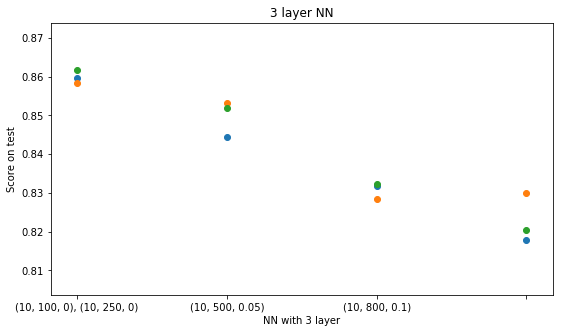

In [98]:
plt.figure(figsize=(9,5))
y0 = [global_score_3[0][0], global_score_3[1][0], global_score_3[2][0], global_score_3[3][0]]
y1 = [global_score_3[0][1], global_score_3[1][1], global_score_3[2][1], global_score_3[3][1]]
y2 = [global_score_3[0][2], global_score_3[1][2], global_score_3[2][2], global_score_3[3][2]]

x = [1,2,3,4]
my_xticks = ['(10, 100, 0), (10, 250, 0)','(10, 500, 0.05)','(10, 800, 0.1)']
plt.xticks(x, my_xticks)
plt.scatter(x, y0)
plt.scatter(x, y1)
plt.scatter(x, y2)

plt.xlabel('NN with 3 layer')
plt.ylabel('Score on test')
plt.title("3 layer NN")
plt.savefig('NN_with_3_layer.jpg')

## Launch result of 4-layer NN - global_score_4 ##

In [170]:
global_score_4 = [array([ 0.60998006,  0.61649985,  0.63304367]),
 array([ 0.78467837,  0.79204267,  0.78794828]),
 array([ 0.78030273 , 0.79163529,  0.79053907]),
 array([ 0.78710824,  0.79302903,  0.78436942])]

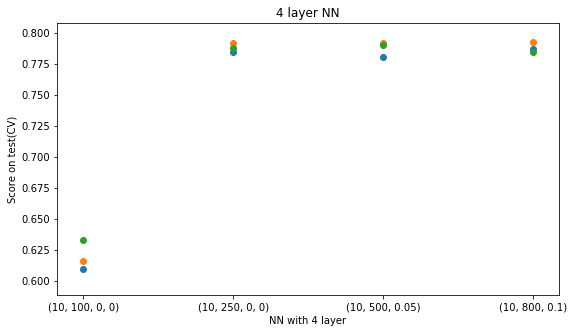

In [171]:
plt.figure(figsize=(9,5))
y0 = [global_score_4[0][0], global_score_4[1][0], global_score_4[2][0], global_score_4[3][0]]
y1 = [global_score_4[0][1], global_score_4[1][1], global_score_4[2][1], global_score_4[3][1]]
y2 = [global_score_4[0][2], global_score_4[1][2], global_score_4[2][2], global_score_4[3][2]]

x = [1,2,3,4]
my_xticks = ['(10, 100, 0, 0)', '(10, 250, 0, 0)','(10, 500, 0.05)','(10, 800, 0.1)']
plt.xticks(x, my_xticks)
plt.scatter(x, y0)
plt.scatter(x, y1)
plt.scatter(x, y2)

plt.xlabel('NN with 4 layer')
plt.ylabel('Score on test(CV)')
plt.title("4 layer NN")
plt.savefig('NN_with_4_layer.jpg')

** Choose 2 layer NN with 100 and 10 units **

## 5. Different regularizers ## 
* Adadelta
* Adagrad lr = 1.0 (default)
* Adagrad lr = 0.5
* Adagrad lr = 0.05 
* Sgd lr = 0.5
* Sgd lr = 0.05
* Sgd lr = 0.01 (best, use for momentum)
* Sgd momentum lr = 0.01, m = 0.9
* Sgd momentum lr = 0.01, m = 0.9

In [161]:
adadelta = [0,8456, 0.8389, 0.8365]
adagrad_05 = [0.7869, 0.7792, 0.7833]
adagrad_1 = [0.7695, 0.7675, 0.7723]
adagrad_005 = [0.8517, 0.8622, 0.8689]
sgd_05 = [0.5110, 0.5846, 0.5010]
sgd_005 = [0.7845, 0.7689, 0.7738]
sgd_001 = [0.7824, 0.7912, 0.7927]
momentum_09 = [0.7705, 0.7627, 0.7721]
momentum_099 = [0.6472, 0.6233, 0.6755]

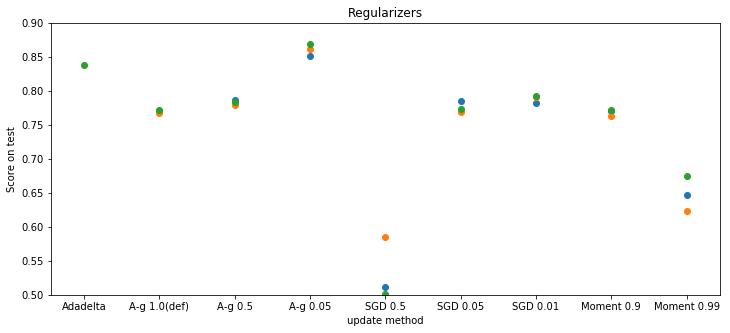

In [164]:
plt.figure(figsize=(12,5))
y0 = [adadelta[0], adagrad_1[0], adagrad_05[0], adagrad_005[0], sgd_05[0], sgd_005[0], sgd_001[0], momentum_09[0], momentum_099[0]]
y1 = [adadelta[1], adagrad_1[1], adagrad_05[1], adagrad_005[1], sgd_05[1], sgd_005[1], sgd_001[1], momentum_09[1], momentum_099[1]]
y2 = [adadelta[2], adagrad_1[2], adagrad_05[2], adagrad_005[2], sgd_05[2], sgd_005[2], sgd_001[2], momentum_09[2], momentum_099[2]]

x = [1,2,3,4,5,6,7, 8, 9]
my_xticks = ['Adadelta','A-g 1.0(def)','A-g 0.5','A-g 0.05', 'SGD 0.5', 'SGD 0.05', 'SGD 0.01', 'Moment 0.9', 'Moment 0.99']
plt.xticks(x, my_xticks)
plt.scatter(x, y0)
plt.scatter(x, y1)
plt.scatter(x, y2)

plt.xlabel('update method')
plt.ylabel('Score on test')
plt.ylim(0.5, 0.9)
plt.title("Regularizers")
plt.savefig('Updates_all.jpg')

## Final score ##

nn2
test 0.810493941989
train 0.81240382917
test 0.883479176448
train 0.889764593284
test 0.897505745991
train 0.904340476749


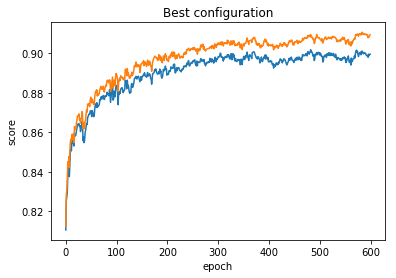

In [165]:
train_fun_best, accuracy_fun_best, predict_fun_best = custom_nn.make_nn2(-2, "All", 100, 10, 0, 0) #2 layer as higher 400 units&
    
test_, train_ = class_helper.single_train(train_fun_best, predict_fun_best, X_train,y_train,  X_val,y_val, 600)

plt.title("Best configuration")
plt.plot(train_,label="train")
plt.plot(test_, label="test")
plt.xlabel("epoch")
plt.ylabel("score")
plt.savefig("NNbestconf.png")
plt.show()